In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#to plot accuracy
import cv2
import tensorflow as tf
from PIL import Image, ImageEnhance
import os
from sklearn.model_selection import train_test_split #to split training and testing data
from pytorch_ood.detector import MaxSoftmax, ODIN, Mahalanobis, KNN
from pytorch_ood.utils import OODMetrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import ConcatDataset,DataLoader, Dataset
from torchvision import transforms
import os
from keras.utils import to_categorical

c:\Users\15854\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [122]:
data, labels = [],[] #half
OpenSetData, OpenSetLabels = [],[] #other half
test_data,test_labels = [],[] #half
test_os_data, test_os_labels = [],[] #other half
classes = 43
cutoffForOpenSet = 43
cur_path = os.getcwd()



#GTSRB Train
for i in range(classes):
   path = os.path.join(cur_path + '//' + "GTSRB",'train',str(i))
   images = os.listdir(path)
   for a in images:
        try:
           image = Image.open(path + '//'+ a)
           image = image.resize((30,30))
           image = np.array(image)
          #sim = Image.fromarray(image)
           if(i < cutoffForOpenSet):
            data.append(image)
            labels.append(i)
          
           else:
            OpenSetData.append(image)
            OpenSetLabels.append(i)
        except:
           print("Error loading image")

#GTSRB Test
path = os.path.join(cur_path + "//" + "GTSRB")
test_df = pd.read_csv(path + '//test.csv')

print(test_df.head(5))
image_path = test_df['Path']
label = test_df['ClassId']
for i in range(len(test_df)):   
   image = Image.open(path + '//' + image_path[i])
   image = image.resize((30,30))
   image = np.array(image)
   if(label[i] < cutoffForOpenSet):
      test_data.append(image)
      test_labels.append(label[i])
      
   else:
      test_os_data.append(image)
      test_os_labels.append(label[i])



x = np.array(data)
y = np.array(labels)

xt = np.array(test_data)
yt = np.array(test_labels)

print(x.shape, y.shape)




#train & test datasets
train_dataset = TrafficSignsDataset(x,y)
test_dataset = TrafficSignsDataset(xt,yt)

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png
(39209, 30, 30, 3) (39209,)


In [130]:
data = []
labels = []
for i in range(10):
   path = os.path.join(cur_path + '//' + "CIFAR-10-images-master",'train',str(i))
   images = os.listdir(path)
   for a in images:
        try:
           image = Image.open(path + '//'+ a)
           image = image.resize((30,30))
           image = np.array(image)
           labels.append(i)
           data.append(image)
        except:
           print("Error loading image")
data_outlier = TrafficSignsDataset(data, labels )

In [169]:
data, labels = [],[]
OpenSetData, OpenSetLabels = [],[]
test_data,test_labels = [],[]
test_os_data, test_os_labels = [],[]
classes = 43
cutoffForOpenSet = 30
cur_path = os.getcwd()
#Retrieving the images and their labels
for i in range(classes):
   path = os.path.join(cur_path + '//' + "GTSRB",'train',str(i))
   images = os.listdir(path)
   for a in images:
        try:
           image = Image.open(path + '//'+ a)
           image = image.resize((30,30))
           image = np.array(image)
          #sim = Image.fromarray(image)
           if(i < cutoffForOpenSet):
            data.append(image)
            labels.append(i)
           else:
            OpenSetData.append(image)
            OpenSetLabels.append(i)
        except:
           print("Error loading image")

#now we get test set
path = os.path.join(cur_path + "//" + "GTSRB")
test_df = pd.read_csv(path + '//test.csv')

print(test_df.head(5))
image_path = test_df['Path']
label = test_df['ClassId']
for i in range(len(test_df)):   
   image = Image.open(path + '//' + image_path[i])
   image = image.resize((30,30))
   image = np.array(image)
   if(label[i] < cutoffForOpenSet):
      test_data.append(image)
      test_labels.append(label[i])
   else:
      test_os_data.append(image)
      test_os_labels.append(label[i])



x = np.array(data)
y = np.array(labels)
xt = np.array(test_data)
yt = np.array(test_labels)


xt2 = np.array(test_os_data)
yt2 = np.array(test_os_labels)
print(x.shape, y.shape)

train_dataset = TrafficSignsDataset(x,y)
test_dataset = TrafficSignsDataset(xt,yt)
openset_test_dataset = TrafficSignsDataset(xt2,yt2)

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png
(31620, 30, 30, 3) (31620,)


No device given. Will use 'cpu'.


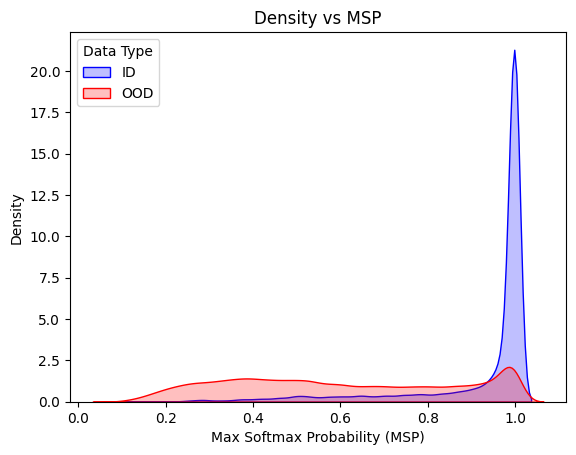

{'AUROC': 0.8512203097343445, 'AUPR-IN': 0.9148035049438477, 'AUPR-OUT': 0.7099347114562988, 'FPR95TPR': 0.34232649207115173}


In [186]:
import seaborn as sns
#we want to plot frequency vs max softmax probs for both ood and id
#we use 10 bins

from pytorch_ood.detector import Mahalanobis
test_msps = []
ood_msps = []
labels,scores = [],[]
return_features = False
#detector = MaxSoftmax(model)

detector = Mahalanobis(model)
detector.fit(train_loader)
metrics = OODMetrics(model)
for x,y in test_loader:
    outputs = model(x)
    score = detector(x)
    scores.extend(score.tolist())
    metrics.update(score, y)
    binary_labels = (y == -1).int()
    labels.extend(binary_labels.tolist())
    softmax_out = F.softmax(outputs, dim = 1)
    max, _ = softmax_out.max(dim = 1)
    test_msps.extend(max.detach().numpy())

for x in ood_loader:
    x = x[0] if isinstance(x, list) else x  # If x is a list, take the first element
    y = torch.tensor([-1] * len(x), dtype=torch.long)
    outputs = model(x)
    score = detector(x)
    metrics.update(score, y)
    scores.extend(score.tolist())
    binary_labels = (y == -1).int()
    labels.extend(binary_labels.tolist())
    softmax_out = F.softmax(outputs, dim = 1)
    max, _ = softmax_out.max(dim = 1)
    ood_msps.extend(max.detach().numpy())
 
sns.kdeplot(test_msps, bw_adjust=0.5, fill=True, color='blue', label='ID')  # Blue for test data
sns.kdeplot(ood_msps, bw_adjust=0.5, fill=True, color='red', label='OOD')   # Red for OOD data


plt.title("Density vs MSP")
plt.xlabel("Max Softmax Probability (MSP)")
plt.ylabel("Density")
plt.legend(title="Data Type")  
plt.show()

print(metrics.compute())

area under curve 0.8512203553717805
{'AUROC': 0.8512203097343445, 'AUPR-IN': 0.9148035049438477, 'AUPR-OUT': 0.7099347114562988, 'FPR95TPR': 0.34232649207115173}


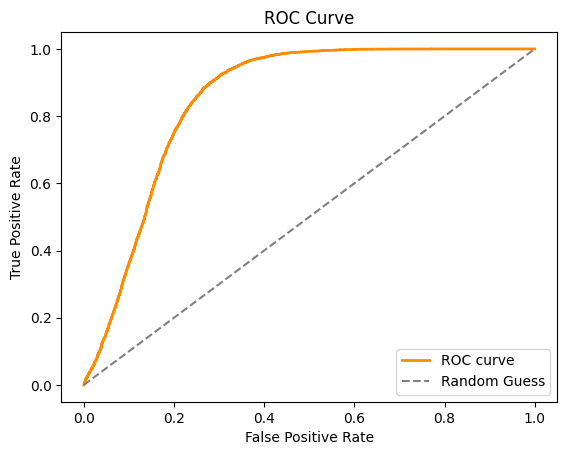

In [187]:

fpr, tpr, thresholds = roc_curve(labels,scores)
roc_auc = auc(fpr,tpr)
print('area under curve', roc_auc)
print(metrics.compute())


plt.figure()
plt.plot(fpr,tpr,color = 'darkorange', lw = 2, label = 'ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

In [173]:
            
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last= True)
outlier_train_loader = DataLoader(data_outlier, batch_size= 32, shuffle= True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
ood_loader = DataLoader(ood_dataset, batch_size=32, shuffle= True )
openset_test_loader = DataLoader(openset_test_dataset, batch_size= 32, shuffle= True)

print(outlier_train_loader.batch_size)

32


In [103]:
ood_data = []
ood_folder = 'C://College//Junior//E2E Deep Learning//Final project//oxford-iiit-pet//images//images'

for ood_img in os.listdir(ood_folder):
    if ood_img.endswith(('.png', '.jpg', '.jpeg')):  
        ood_image_path = os.path.join(ood_folder, ood_img)
        ood_image = Image.open(ood_image_path).convert('RGB')
        ood_image = ood_image.resize((30, 30)) 
        x = np.array(ood_image)
        if x.shape == (30, 30, 3): 
                ood_data.append(x)
oodlab = len(ood_data) * [1]
x = np.array(ood_data)

ood_dataset = TrafficSignsDataset(x, oodlab) 
print(x.shape)

(7390, 30, 30, 3)


In [183]:
epochs = 6
batch_size = 32
train_features = []
loss_avg  = 1

model = TrafficSignNet()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0 
    total_samples = 0 

    for inputs, labels in train_loader:  
      
        optimizer.zero_grad()
        outputs = model(inputs)
        #train_features.append(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  
        correct_predictions += (predicted == labels).sum().item()  
        total_samples += labels.size(0)


    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

    print(f"test loss {test_loss}, and accuracy {test_accuracy}")
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")
    epoch_accuracy = correct_predictions / total_samples
    print("Epoch Accuracy", epoch_accuracy)




'''
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0 
    total_samples = 0 

    #for inputs, labels in train_loader: 
    for in_set, out_set in zip(train_loader, outlier_train_loader):
        data = torch.cat((in_set[0], out_set[0]), 0)
        target = in_set[1]


        # forward
        x = model(data)


        optimizer.zero_grad()

        loss = F.cross_entropy(x[:len(in_set[0])], target)
        # cross-entropy from softmax distribution to uniform distribution
        loss += 0.5 * -(x[len(in_set[0]):].mean(1) - torch.logsumexp(x[len(in_set[0]):], dim=1)).mean()

        loss.backward()
        optimizer.step()


    print("train loss", loss_avg)

    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    #train_features_tensor = torch.cat(train_features, dim = 0)

    print(f"test loss {test_loss}, and accuracy {test_accuracy}")
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")
    #epoch_accuracy = correct_predictions / total_samples
    print("Epoch Accuracy", epoch_accuracy)
'''

# Save the model
torch.save(model.state_dict(), "my_model.pth")

test loss 0.5230251792996743, and accuracy 0.849266862170088
Epoch 1/6, Loss: 1.3241759456301991
Epoch Accuracy 0.619369939271255
test loss 0.4524211604399415, and accuracy 0.8712609970674486
Epoch 2/6, Loss: 0.6205334043288641
Epoch Accuracy 0.8110766700404858
test loss 0.364135036621159, and accuracy 0.9048875855327468
Epoch 3/6, Loss: 0.5102284542296217
Epoch Accuracy 0.8426429655870445
test loss 0.32907320797763845, and accuracy 0.9185728250244379
Epoch 4/6, Loss: 0.4679086231947066
Epoch Accuracy 0.8542826417004049
test loss 0.40134424515367134, and accuracy 0.9067448680351906
Epoch 5/6, Loss: 0.42734367530114253
Epoch Accuracy 0.8694648279352226
test loss 0.3071317467157559, and accuracy 0.9178885630498533
Epoch 6/6, Loss: 0.40833926335851917
Epoch Accuracy 0.8749051113360324


In [8]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for x, y in test_loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item() * x.size(0)  # Sum loss over the batch
            _, predicted = outputs.max(1)  # Get class with highest probability
            correct += (predicted == y).sum().item()
            total += y.size(0)
    
    avg_loss = test_loss / total  # Average loss over all test samples
    accuracy = correct / total  # Accuracy as a fraction
    return avg_loss, accuracy

In [162]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 256)  # Adjust input size after pooling
        self.fc2 = nn.Linear(256, 43)

        # Dropout layers
        self.dropout_conv = nn.Dropout(p=0.25)
        self.dropout_fc = nn.Dropout(p=0.5)

    def forward(self, x):
        # First Conv block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout_conv(x)

        # Second Conv block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout_conv(x)

        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        # Fully connected layers
        features = F.relu(self.fc1(x))
        x = self.dropout_fc(features)
        logits = self.fc2(x)
      
        
        return logits

# Instantiate the model





In [5]:
class TrafficSignsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)

        return image, label
